In [1]:
import pandas as pd
import spacy
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import fasttext.util
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Pipeline für Textklassifikation mit fasttext

## Datenvorbereitung

In [2]:
# load data
sample = pd.read_csv("data/labeled_unprocessed_sample_data.csv", sep=";")

In [3]:
# remove possible missing values and duplicates
sample = sample.dropna()
sample = sample.drop_duplicates(subset="answer")

In [4]:
nlp = spacy.load("de_core_news_sm")

def text_lemmatization(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_punct]
    return " ".join(lemmas)

In [5]:
def text_preprocessing(text):
    # remove links, punctuation, special letters
    text = re.sub(r"[^a-zA-öZÖäÄüÜß]|\bhttps?://\S*|&\w+;|[\.,]", " ", text)
    
    # replace single characters
    text = re.sub(r" [a-zA-Z] ", " ", text)
    
    # remove additional whitespaces
    text = re.sub(r"\s+", " ", text)
    
    # lemmatize texts
    text = text_lemmatization(text)

    # lower text
    text = text.lower()
    
    # tokenization of words
    text = text.split()
    
    # remove stopwords
    german_stopwords = set(stopwords.words("german"))
    text = [w for w in text if w not in german_stopwords]
    
    # return joined text
    return " ".join(text)

In [6]:
sample["clean_answer"] = sample["answer"].apply(text_preprocessing)

In [7]:
# show most frequent words
vectorizer = CountVectorizer(
)
dtm = vectorizer.fit_transform(sample["clean_answer"])

frequencies = dtm.sum(axis=0).tolist()[0]

df_freq = pd.DataFrame(
    dict(frequencies=frequencies,
         index=vectorizer.get_feature_names_out()
    )
)

df_freq.sort_values("frequencies", ascending=False).head(n=20)

,frequencies,index
9221,2012,geehrt
8766,1718,freundlich
24838,1712,vieler
11383,1698,herr
8594,1579,frage
4977,1279,dank
20807,971,sollen
15637,942,mensch
9138,900,geben
10810,898,gut


In [8]:
# remove stopwords with refined list and after lemmatization to catch 
def remove_individual_stopwords(text):
    individual_stopwords = [
        "geehrt",
        "frau",
        "vieler",
        "dank",
        "herr",
        "danke",
        "anfrage",
        "frage",
        "nachricht",
        "freundlich",
        "sollen",
        "müssen",
        "mehr",
        "grüße",
        "daher",
        "immer",
        "dafür",
        "frage"
    ]
    text = text.split()
    text = [w for w in text if w not in individual_stopwords]
    
    return " ".join(text)

In [9]:
sample["clean_answer"] = sample["clean_answer"].apply(remove_individual_stopwords)

In [10]:
# prepare data for processing by fasttext
sample["answer_encoded"] = sample["answer_encoded"].apply(lambda x: x.replace(" ", "_"))
sample["answer_encoded"] = sample["answer_encoded"].apply(lambda x: "__label__" + x)
sample["answer_encoding_combined"] = sample["answer_encoded"]+ " " + sample["clean_answer"]

In [11]:
# seperate sample data into training, test and validation sets (80/10/10)
training_sample, temp_df = train_test_split(sample, test_size=0.2, random_state=42)
testing_sample, validation_sample = train_test_split(temp_df, test_size=0.5, random_state=42)

In [12]:
# export datasets
training_sample["answer_encoding_combined"].to_csv("data/training_data.csv", index=False, header=False, sep=";")
testing_sample["answer_encoding_combined"].to_csv("data/testing_data.csv", index=False, header=False, sep=";")
validation_sample["answer_encoding_combined"].to_csv("data/validation_data.csv", index=False, header=False, sep=";")

## Modelltraining

### Ohne optimierte Hyperparamater

In [13]:
# train model without optimizing the hyperparameter
ft_model = fasttext.train_supervised(input="data/training_data.csv")

In [14]:
# test model
ft_model.test("data/testing_data.csv")

(228, 0.6535087719298246, 0.6535087719298246)

### Mit optimierten Hyperparametern

In [15]:
# train model with optimizing the hyperparameter
ft_model_optimized = fasttext.train_supervised(
    input="data/training_data.csv", 
    autotuneValidationFile="data/validation_data.csv"
    )

In [16]:
# test model
ft_model_optimized.test("data/testing_data.csv")

(228, 0.6798245614035088, 0.6798245614035088)

#### Testergebnisse für Label "answer"

In [39]:
# test model for label "answer"
answer_test = ft_model_optimized.test_label("data/testing_data.csv")["__label__answer"]

#### Testergebnisse für Label "evasive answer"

In [40]:
# test model for label "evasive answer"
evasive_answer_test = ft_model_optimized.test_label("data/testing_data.csv")["__label__evasive_answer"]

### Visualisierung von Testergebnissen für die Label

In [ ]:
# create dataframe with values from testing
df_testing_results = pd.DataFrame([answer_test, evasive_answer_test])
df_testing_results.insert(0, "label", ["answer", "evasive answer"])

# change from wide to long dataframe format
heatmap_data = df_testing_results.melt(
    id_vars="label",
    value_vars=["precision", "recall"],
    var_name="Metric",
    value_name="Value"
)

,label,Metric,Value
0,answer,precision,0.680000
1,evasive answer,precision,0.678571
2,answer,recall,0.937931
3,evasive answer,recall,0.228916


[Text(0.5, 20.049999999999997, 'Metrik'),
 Text(47.24999999999999, 0.5, 'Label'),
 Text(0.5, 1.0, 'Konfusionsmatrix mit Ergebnissen der Modelltests')]

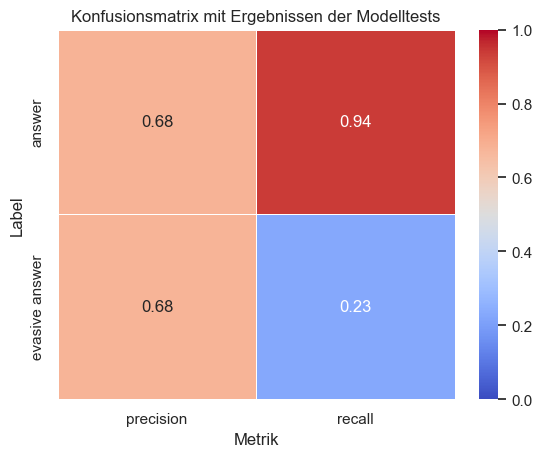

In [65]:
# create confusion matrix for model results
sns.set_theme()
ax = sns.heatmap(
   data=heatmap_data.pivot(index="label", columns="Metric", values="Value"),
   annot=True,
   linewidths=0.5,
   vmin=0,
   vmax=1,
   cmap="coolwarm"
)
ax.set(
    xlabel="Metrik",
    ylabel="Label",
    title="Konfusionsmatrix mit Ergebnissen der Modelltests"
)

In [19]:
# save trained model
ft_model_optimized.save_model("model/classification.bin")

## Modellanwendung

### Laden und Vorverarbeiten der Daten

In [20]:
# load unprocessed data without sample
data = pd.read_csv("data/data_without_sample.csv", sep=";")

In [21]:
# drop na and duplicates in answers
data = data.drop_duplicates(subset=["answer", "question_text"])
data = data.dropna(subset=["answer"])

In [22]:
# apply text cleaning
data["clean_answer"] = data["answer"].apply(text_preprocessing)
data["clean_answer"] = data["clean_answer"].apply(remove_individual_stopwords)


### Automatisches Labeln der Antworten

In [23]:
# extract answers from colums
text = data["clean_answer"].tolist()

In [24]:
# predict label and probability of label for each answer
labels, probalities = ft_model_optimized.predict(text, k=1)

### Nachbearbeiten der Labels und Probabilities für bessere Lesbarkeit

In [25]:
def flatten_list(list):
    flattened_list = []
    for item in list:
        for i in item:
            flattened_list.append(i)
    return flattened_list

flattened_labels = flatten_list(labels)
flattened_probabilities = flatten_list(probalities)

In [26]:
# append labels and probabilities to dataframe
data["label"] = flattened_labels
data["probability"] = flattened_probabilities

In [27]:
data["label"] = data["label"].apply(lambda x: x.replace("__label__", ""))

## Analyse der vergebenen Labels

1. Durchschnitt von
    - allen Labels
    - answer
    - evasive answer
    - nach Gruppe
2. Visualisierungen
    - despine (?) nutzen

### Deskriptive Auswertung Wahrscheinlichkeit der Labels korrekt zugeordnet zu werden

In [ ]:
# mean, median and std of the labels probability to be correct
df_labels = data.groupby("label")
df_labels.agg({"probability" : ["mean", "median", "std"]})

probability                    
                      mean    median       std
label                                         
answer            0.682314  0.687535  0.077785
evasive_answer    0.699639  0.660384  0.155366

### Verteilung der Labels

Text(0.5, 1.0, "Häufigkeit der Labels 'answer' und 'evasive answer'")

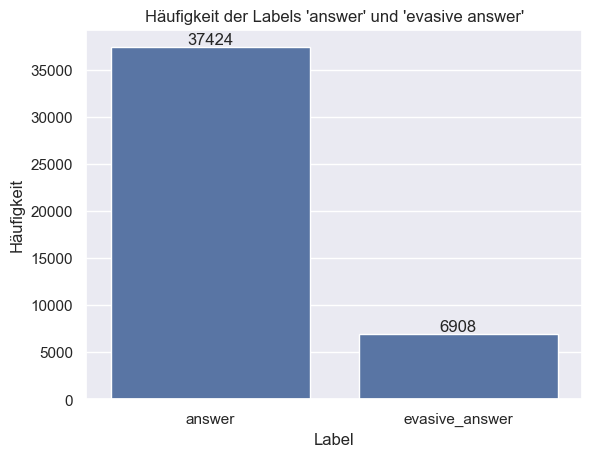

In [ ]:
# create plot
sns.set_theme()
ax = sns.countplot(
    data=data,
    x="label"
)

# add value-label over bar
for i in ax.containers:
    ax.bar_label(i)

# add text to axis
plt.xlabel("Label")
plt.ylabel("Häufigkeit")
plt.title("Häufigkeit der Labels 'answer' und 'evasive answer'")
